# Togo Fiber Optics Uptake Prediction Challenge

# I. Introduction
L'objectif de cette compétition est de **développer une solution de machine learning pour prédire l'adoption de l'internet par fibre optique (FTTH)** dans différents segments au Togo en utilisant des ensembles de données sociodémographiques et géographiques. Le but est de créer des **modèles précis et généralisables** afin d'aider le gouvernement à améliorer la connectivité, allouer les ressources de manière efficiente, et promouvoir l'inclusion numérique.
Consulter le portail [pour plus d'infos](https://zindi.africa/competitions/togo-fiber-optics-uptake-prediction-challenge).

### *Public Score : 0.923651326*
### *Private Score : 0.92660404*

HYPOTHESES FAITES DURANT LA RECHERCHE D'UNE APPROCHE DE SOLUTION.
* Convergence de l'API MOSAIKS [Résolu]
* Données dupliquées [Résolu]
* Encodage des caractères [Résolu]
* Ré-équilibrage de la variable Target [Résolu]
* Expérimenter avec le fillna() [Résolu]
* Analyse des variables terminant par Y [Résolu]
* Doublons sur les valeurs uniques [Résolu]
* Désactiver le train_test_split [Résolu]
* Valeurs manquantes sur la variable Connexion (Togocom et GVA) [Résolu]
* Ne pas supprimer les doublons [Résolu]
* Ne pas arrondir les probabilités pour améliorer son score [Résolu]
* Vérifier les feature_importances_ [Résolu]
* Matrice de corrélation [Résolu]

* ***Analyser minitieusement la distribution des variables***
* ***Réaliser des boxplots***
* ***Test de vérification (observation significativement valide)***

# *Configurations*

In [1]:
# DECOMMENTER SI LIBRAIRIE optuna EST MANQUANTE
# !pip install optuna

# DECOMMENTER SI LE FICHIER requirements.txt JOINT AU CODE SOURCE
# !pip install -r requirements.txt

In [2]:
# Importation des librairies requises 
import time
import optuna
import os, sys
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.cm
import seaborn as sns
from sklearn.svm import SVC
from sklearn import set_config
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.compose import make_column_selector
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.compose import make_column_transformer
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

In [3]:
# Définition du random seed (pour la reproductibilité)
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [4]:
# Définition du StratifiedKFold
SKF = StratifiedKFold(random_state=RANDOM_SEED, n_splits=5, shuffle=True,)

In [5]:
# Nombre de colonnes à afficher et configuration des retours dataframes
pd.options.display.max_columns = 5000
set_config(transform_output="pandas")

In [6]:
# À modifier en fonction de votre enviromment d'éxécution
data_input = '/kaggle/input/zd-tg-ds'
data_output = '/kaggle/working/' 

*Les estimations du [CPU TIMES: TOTAL:] sont basés sur la probabilité que tous les processeurs disponibles (04 sur Kaggle) sont utilisés en mode THREADINGBACKEND et non LOKYBACKEND. Toutefois il est à noter que Kaggle ne permet pas la modification manuelle de ces configurations. Ceux-ci indiqués sont approximatives.*

*Le temps d'exécution peut donc varier en fonction du nombre de processeurs alloués et la méthode d'éxécution en parallèle utilisé.*

# *1. Informations générales sur les datasets*

Les données des clients de la fibre optique jusqu'au domicile (FTTH) ont été collectées auprès des opérateurs Togocom et GVA. Les données du recensement général de la population et de l'habitat (RGPH) proviennent de l'Institut national de la statistique et des études économiques et démographiques du Togo (INSEED).

L'ensemble de données collectées provient d'agents fournissant des services de télécommunications, y compris la vente de crédit, de cartes SIM et de connexions internet (data). L'unité administrative de base prise en compte dans cette étude est la commune.

In [7]:
%%time
### CPU times: total: 2min 11s (Kaggle)

# Chargement des données
train1_data = pd.read_csv(data_input+'Train.csv', encoding='utf-8-sig')
train2_data = pd.read_csv(data_input+'train_2.csv', encoding='utf-8-sig')
test_data = pd.read_csv(data_input+'Test.csv', encoding='utf-8-sig')

# Fusion des jeux de données
train_data = pd.concat([train1_data, train2_data], ignore_index=True)

CPU times: user 1min 25s, sys: 6.14 s, total: 1min 31s
Wall time: 2min 14s


In [8]:
# Suppression des données redondantes sur l'axe ID
display(train_data.shape)
train_data = train_data.drop_duplicates(subset=['ID'])
train_data.shape

(46733, 4043)

(30558, 4043)

In [9]:
# Renommer les colonnes nécessaires
train_data.rename(columns={"Accès internet": "Target"}, inplace=True)
train_data.rename(columns={" ": "MOSAIK_FEATURE"}, inplace=True)
test_data.rename(columns={" ": "MOSAIK_FEATURE"}, inplace=True)

In [10]:
# Copie des ID du dataset de test_data pour utilisation future
test_ID = test_data.ID
test_ID

0        ID_6R2X9XE3RA
1        ID_1CQDGXQJW9
2        ID_5DQVKM2ODB
3        ID_65TQFKG2L2
4        ID_NBG4Q4OAF2
             ...      
13092    ID_3KWN9MJRAN
13093    ID_T9UH62RBN4
13094    ID_402PU8JV7H
13095    ID_Z565FBVM3P
13096    ID_KC5XV7HRFE
Name: ID, Length: 13097, dtype: object

In [11]:
# Aperçu du dataset train_data
train_data.head()

ID            TypeLogmt_1         TypeLogmt_2  \
0  ID_88M0FMHZAM  Logement semi-moderne  Plusieurs logement   
1  ID_8BRUVGMYT4  Logement semi-moderne  Plusieurs logement   
2  ID_BLWKMPQSDG       Logement moderne  Plusieurs logement   
3  ID_5FF71INFJ2       Logement moderne  Plusieurs logement   
4  ID_BL1YKKNQ4Y       Logement moderne  Plusieurs logement   

                         TypeLogmt_3  \
0  Logement � un niveau (plain-pied)   
1  Logement � un niveau (plain-pied)   
2  Logement � un niveau (plain-pied)   
3  Logement ? un niveau (plain-pied)   
4  Logement � un niveau (plain-pied)   

                                       H08_Impute       H09_Impute  \
0  Electricit� (CEET) compteur dans la concession              Gaz   
1  Electricit� (CEET) compteur dans la concession              Gaz   
2  Electricit� (CEET) compteur dans la concession  Charbon de bois   
3  Electricit? (CEET) compteur dans la concession              Gaz   
4  Electricit� (CEET) compteur dans la concession  Charbon de bois   

   TAILLE_MENAGE H17A H17B H17C H17D H17E H17F H17G H17H H17I H17J H17Y H18A  \
0            1.0  Non  Oui  Non  Non  Non  Non  Non  Non  Non  Non  Non  Oui   
1            4.0  Non  Oui  Non  Non  Non  Non  Non  Non  Non  Non  Non  Oui   
2            1.0  Non  Non  Non  Non  Non  Non  Non  Non  Non  Non  Oui  Non   
3            4.0  Non  Non  Non  Non  Non  Non  Non  Non  Non  Non  Oui  Oui   
4            1.0  Non  Non  Non  Non  Non  Non  Non  Non  Non  Non  Oui  Oui   

  H18B H18C H18D H18E H18F H18G H18H H18I H18J H18Y H20A H20B H20C H20D H20E  \
0  Non  Non  Non  Non  Non  Non  Non  Non  Non  Non  Oui  Oui  Non  Non  Non   
1  Non  Non  Non  Oui  Non  Non  Non  Non  Non  Non  Oui  Non  Oui  Non  Oui   
2  Non  Non  Non  Non  Non  Non  Non  Non  Non  Oui  Non  Non  Non  Non  Non   
3  Non  Oui  Oui  Oui  Non  Non  Non  Non  Non  Non  Oui  Non  Non  Non  Non   
4  Non  Non  Non  Non  Non  Non  Non  Non  Non  Non  Non  Non  Non  Non  Non   

  H20Y H21A H21B H21C H21D H21Y Connexion BoxLabel  MOSAIK_FEATURE        .1  \
0  Non  Non  Non  Non  Non  Oui       GVA     Box0        0.110878  0.364513   
1  Non  Non  Non  Non  Non  Oui       GVA     Box0        0.070467  0.174473   
2  Oui  Non  Non  Non  Non  Oui       GVA     Box0        0.184448  0.529424   
3  Non  Non  Non  Non  Non  Oui   Togocom     Box0        0.173134  0.488908   
4  Oui  Non  Non  Non  Non  Oui       NaN     Box0        0.166340  0.532463   

         .2        .3        .4        .5        .6        .7        .8  \
0  0.082156  0.050989  0.180205  0.440745  0.091101  0.350169  0.012656   
1  0.077245  0.009509  0.065423  0.181117  0.089368  0.513371  0.007979   
2  0.038106  0.408890  0.344663  0.368679  0.098398  0.116663  0.328337   
3  0.044793  0.299539  0.313499  0.426035  0.083545  0.120959  0.212011   
4  0.034355  0.400996  0.301856  0.404993  0.072722  0.101579  0.324310   

         .9       .10       .11       .12       .13       .14       .15  \
0  0.414666  0.115399  0.195980  0.336563  0.078171  0.100897  0.045542   
1  0.136733  0.148871  0.215091  0.277986  0.097039  0.108392  0.027131   
2  0.416548  0.443309  0.008673  0.528200  0.228227  0.311227  0.089162   
3  0.442777  0.402828  0.013082  0.485119  0.200724  0.273746  0.076230   
4  0.436339  0.435887  0.013975  0.507274  0.217213  0.290129  0.086353   

        .16       .17       .18       .19       .20       .21       .22  \
0  0.913928  0.018699  0.380138  0.607484  0.277331  0.138209  0.276000   
1  0.401973  0.002417  0.191969  0.224114  0.172935  0.127753  0.355751   
2  0.753857  0.331376  0.157631  0.465878  0.324238  0.155823  0.175883   
3  0.876149  0.223612  0.191062  0.541943  0.298798  0.165449  0.199614   
4  0.792113  0.328174  0.170184  0.524298  0.316551  0.141803  0.167701   

        .23       .24       .25       .26       .27       .28       .29  \
0  0.066287  0.258161  0.288994  0.682467  0.254205  0.464460  0.478994   
1  0.037032  0.119602  0.13

In [12]:
# Modalité incompréhensible de certaines variables
train_data.TypeLogmt_3.value_counts(dropna=False)

TypeLogmt_3
Logement � un niveau (plain-pied)         19733
Logement ? un niveau (plain-pied)          7237
Logement � plusieurs niveaux (� �tage)     2184
Logement ? plusieurs niveaux (? ?tage)     1239
Autre                                       165
Name: count, dtype: int64

In [13]:
# Gestion de l'encodage des charactères du dataset
tl3_map = {
    'Logement � un niveau (plain-pied)': 'Logement a un niveau (plain-pied)',
    'Logement ? un niveau (plain-pied)': 'Logement a un niveau (plain-pied)',
    'Autre': 'Autre',
    'Logement � plusieurs niveaux (� �tage)': 'Logement a plusieurs niveaux (a etage)',
    'Logement ? plusieurs niveaux (? ?tage)': 'Logement a plusieurs niveaux (a etage)'
}
h8_map = {
    'Electricit� (CEET) compteur dans la concession': 'Electricite (CEET) compteur dans la concession',
    'Electricit? (CEET) compteur dans la concession': 'Electricite (CEET) compteur dans la concession',
    'Electricit� (CEET) compteur hors concession': 'Electricite (CEET) compteur hors concession',
    'Electricit? (CEET) compteur hors concession': 'Electricite (CEET) compteur hors concession',
    'C�blage d��lectricit� du voisinnage': 'Cablage d electricite du voisinnage',
    'C?blage d??lectricit? du voisinnage': 'Cablage d electricite du voisinnage',
    'Autre (� pr�ciser)': 'Autre (A preciser)',
    'Autre (? pr?ciser)': 'Autre (A preciser)',
    'Lampe � p�trole': 'Lampe a petrole',
    'Lampe ? p?trole': 'Lampe a petrole',
    'Groupe �lectrog�ne': 'Groupe electrogene',
    'Groupe ?lectrog?ne': 'Groupe electrogene',
    'Lampe � gaz': 'Lampe a gaz',
    'Lampe ? gaz': 'Lampe a gaz',
    'Lampion': 'Lampion',
    'Torche/bougie': 'Torche/bougie',
    'Energie solaire': 'Energie solaire',
}
h9_map = {
    '�lectricit�': 'electricite',
    '?lectricit?': 'electricite',
    'P�trole': 'Petrole',
    'P?trole': 'Petrole',
    'Autre (� pr�ciser)': 'Autre (A preciser)',
    'Autre (? pr?ciser)': 'Autre (A preciser)',
    'R�sidus v�g�taux/sciure de bois': 'Residus vegetaux/sciure de bois',
    'R?sidus v?g?taux/sciure de bois': 'Residus vegetaux/sciure de bois',
    'Bouse d�animaux': 'Bouse d animaux',
    'Bouse d?animaux': 'Bouse d animaux',
    'Charbon de bois': 'Charbon de bois',
    'Gaz': 'Gaz',
    'Ne cuisine pas': 'Ne cuisine pas',
    'Bois de chauffe': 'Bois de chauffe',
}

train_data['TypeLogmt_3'] = train_data['TypeLogmt_3'].map(tl3_map)
train_data['H08_Impute'] = train_data['H08_Impute'].map(h8_map)
train_data['H09_Impute'] = train_data['H09_Impute'].map(h9_map)

test_data['TypeLogmt_3'] = test_data['TypeLogmt_3'].map(tl3_map)
test_data['H08_Impute'] = test_data['H08_Impute'].map(h8_map)
test_data['H09_Impute'] = test_data['H09_Impute'].map(h9_map)

In [14]:
# Vérification
train_data.TypeLogmt_3.value_counts(dropna=False)

TypeLogmt_3
Logement a un niveau (plain-pied)         26970
Logement a plusieurs niveaux (a etage)     3423
Autre                                       165
Name: count, dtype: int64

In [15]:
# Informations générales sur le train_data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30558 entries, 0 to 30557
Columns: 4043 entries, ID to Target
dtypes: float64(4001), int64(1), object(41)
memory usage: 942.8+ MB


In [16]:
# Informations générales sur le test_data
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13097 entries, 0 to 13096
Columns: 4042 entries, ID to  .3999
dtypes: float64(4001), object(41)
memory usage: 403.9+ MB


In [17]:
# Statistique descriptive des données numériques
train_data.describe()

TAILLE_MENAGE  MOSAIK_FEATURE            .1            .2  \
count   30558.000000    30558.000000  30558.000000  30558.000000   
mean        4.475915        0.206314      0.528811      0.079791   
std         2.934860        0.132264      0.297318      0.068620   
min         1.000000        0.003657      0.013529      0.004931   
25%         2.000000        0.115673      0.364513      0.038801   
50%         4.000000        0.179487      0.532363      0.048690   
75%         6.000000        0.266084      0.701194      0.091743   
max        36.000000        0.714337      1.435041      0.410256   

                 .3            .4            .5            .6            .7  \
count  30558.000000  30558.000000  30558.000000  30558.000000  30558.000000   
mean       0.314745      0.334572      0.479224      0.147230      0.250795   
std        0.211992      0.209262      0.287776      0.100688      0.171587   
min        0.000000      0.003523      0.024215      0.030554      0.020446   
25%        0.161350      0.209651      0.322518      0.081526      0.110830   
50%        0.333702      0.321623      0.416750      0.101263      0.168441   
75%        0.452244      0.454778      0.580604      0.171441      0.352279   
max        0.937503      1.010105      1.664593      0.637903      0.978567   

                 .8            .9           .10           .11           .12  \
count  30558.000000  30558.000000  30558.000000  30558.000000  30558.000000   
mean       0.245560      0.456180      0.402217      0.099812      0.510711   
std        0.180839      0.268428      0.244777      0.110682      0.272823   
min        0.000000      0.015397      0.000789      0.001788      0.009578   
25%        0.098520      0.288529      0.235955      0.013975      0.375565   
50%        0.242293      0.436339      0.420004      0.029083      0.517340   
75%        0.357327      0.563009      0.537072      0.199501      0.662112   
max        0.811333      1.367974      1.121930      0.557314      1.326453   

                .13           .14           .15           .16           .17  \
count  30558.000000  30558.000000  30558.000000  30558.000000  30558.000000   
mean       0.233825      0.289620      0.108192      0.886618      0.251457   
std        0.151886      0.178877      0.086236      0.467547      0.183021   
min        0.001512      0.000574      0.000781      0.085226      0.000000   
25%        0.137252      0.179175      0.046204      0.576925      0.107311   
50%        0.227442      0.290129      0.086353      0.827846      0.250775   
75%        0.311110      0.406152      0.148017      1.018256      0.365309   
max        0.709851      0.806096      0.394896      2.678964      0.818909   

                .18           .19           .20           .21           .22  \
count  30558.000000  30558.000000  30558.000000  30558.000000  30558.000000   
mean       0.265458      0.594153      0.344860      0.203140      0.259289   
std        0.170882      0.347234      0.203158      0.135916      0.160434   
min        0.017917      0.035800      0.009041      0.020480      0.033387   
25%        0.154696      0.395562      0.235015      0.114280      0.149314   
50%        0.186558      0.529374      0.327152      0.166340      0.190972   
75%        0.322913      0.723328      0.448989      0.231829      0.335183   
max        1.051340      1.962410      1.029410      0.805321      1.004431   

                .23           .24           .25           .26           .27  \
count  30558.000000  30558.000000  30558.000000  30558.000000  30558.000000   
mean       0.276816      0.423012      0.618578      0.777357      0.274137   
std        0.169270      0.242460      0.354320      0.411273      0.161764   
min        0.001369      0.004281      0.006645      0.081886      0.017947   
25%        0.191232      0.288001      0.399006      0.466811      0.181989   
50%        0.291496      0.450536      0.648866      0.701378      0.234

In [18]:
# Statistiques descriptives des données catégorielles
train_data.describe(include='object')

,ID,TypeLogmt_1,TypeLogmt_2,TypeLogmt_3,H08_Impute,H09_Impute,H17A,H17B,H17C,H17D,H17E,H17F,H17G,H17H,H17I,H17J,H17Y,H18A,H18B,H18C,H18D,H18E,H18F,H18G,H18H,H18I,H18J,H18Y,H20A,H20B,H20C,H20D,H20E,H20Y,H21A,H21B,H21C,H21D,H21Y,Connexion,BoxLabel
count,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,30558,20050,30558
unique,30558,4,3,3,10,9,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1
top,ID_88M0FMHZAM,Logement moderne,Plusieurs logement,Logement a un niveau (plain-pied),Electricite (CEET) compteur dans la concession,Charbon de bois,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,GVA,Box0
freq,1,17892,18051,26970,24040,17277,28058,17309,29844,30248,30464,25052,30118,30547,30534,30528,17923,22336,27840,22943,25596,19807,28913,28909,25504,29911,30390,23205,19342,21879,15442,29941,23650,26036,30426,30507,29587,29258,28248,10420,30558


In [19]:
# Modalité des variables
train_data.select_dtypes('object').nunique().sort_values(ascending=False)

ID             30558
H08_Impute        10
H09_Impute         9
TypeLogmt_1        4
TypeLogmt_2        3
TypeLogmt_3        3
H20D               2
H18I               2
H18J               2
H18Y               2
H20A               2
H20B               2
H20C               2
H21A               2
H20E               2
H20Y               2
H18G               2
H21B               2
H21C               2
H21D               2
H21Y               2
Connexion          2
H18H               2
H18D               2
H18F               2
H17G               2
H17A               2
H17B               2
H17C               2
H17D               2
H17E               2
H17F               2
H17H               2
H18E               2
H17I               2
H17J               2
H17Y               2
H18A               2
H18B               2
H18C               2
BoxLabel           1
dtype: int64

In [20]:
# Proportion de valeurs manquantes
((train_data.isna().sum())/train_data.shape[0]).sort_values(ascending=False)

Connexion    0.343871
ID           0.000000
 .2674       0.000000
 .2645       0.000000
 .2646       0.000000
               ...   
 .1311       0.000000
 .1312       0.000000
 .1313       0.000000
 .1314       0.000000
Target       0.000000
Length: 4043, dtype: float64

In [21]:
# Examen de la colonne target (%)
train_data.Target.value_counts(normalize=True)

Target
0    0.512141
1    0.487859
Name: proportion, dtype: float64

In [22]:
for column in train_data.select_dtypes('object'):
    if len(column) != 4 and column != 'ID':
        if len(train_data[column].value_counts()) != 2:
            print(f'{column :<50} \n{train_data[column].unique()}\n')
        else:
            print(f'{column :<50} {train_data[column].unique()}')

TypeLogmt_1                                        
['Logement semi-moderne' 'Logement moderne' 'Autre'
 'Logement traditionnel']

TypeLogmt_2                                        
['Plusieurs logement' 'Logement unique' 'Autre']

TypeLogmt_3                                        
['Logement a un niveau (plain-pied)'
 'Logement a plusieurs niveaux (a etage)' 'Autre']

H08_Impute                                         
['Electricite (CEET) compteur dans la concession'
 'Electricite (CEET) compteur hors concession' 'Lampion' 'Torche/bougie'
 'Energie solaire' 'Cablage d electricite du voisinnage'
 'Autre (A preciser)' 'Lampe a petrole' 'Groupe electrogene' 'Lampe a gaz']

H09_Impute                                         
['Gaz' 'Charbon de bois' 'Ne cuisine pas' 'Bois de chauffe' 'electricite'
 'Petrole' 'Autre (A preciser)' 'Residus vegetaux/sciure de bois'
 'Bouse d animaux']

Connexion                                          ['GVA' 'Togocom' nan]
BoxLabel                       

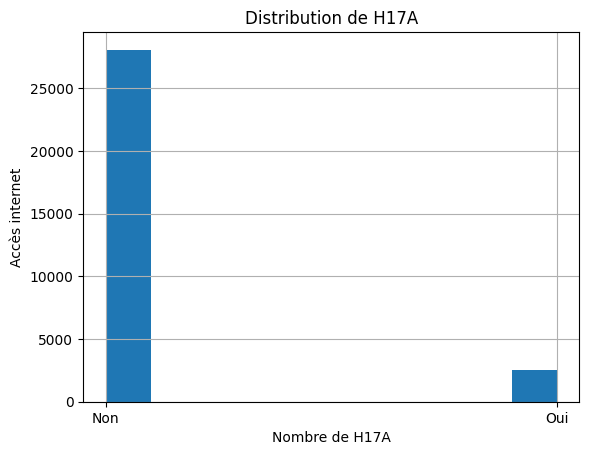

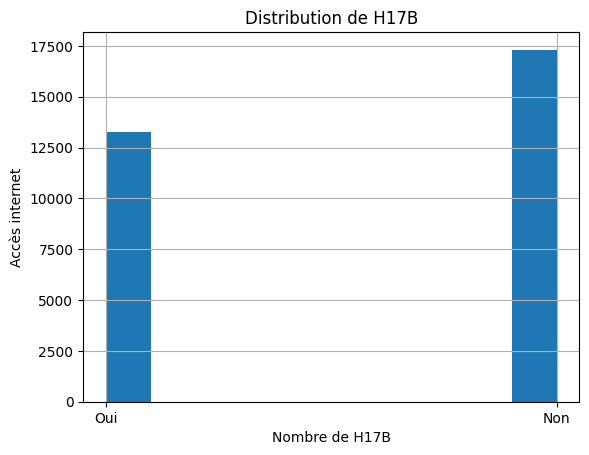

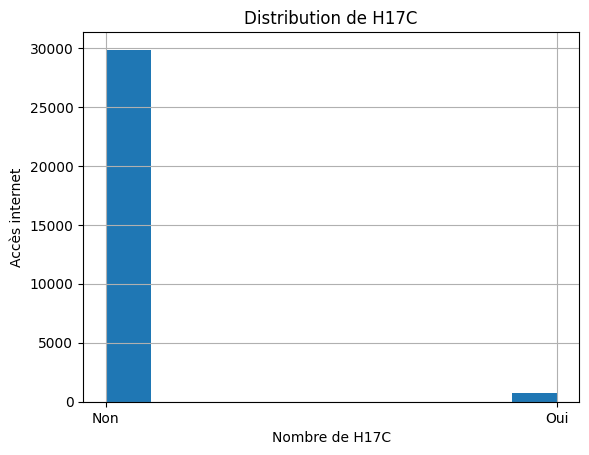

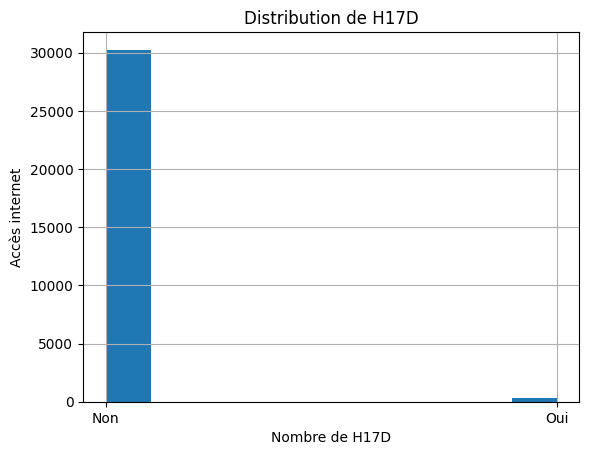

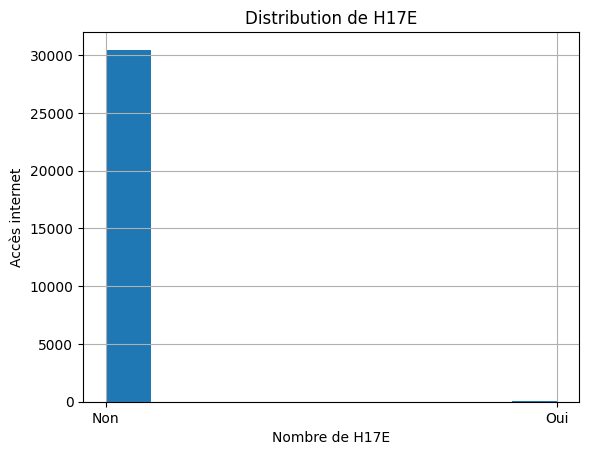

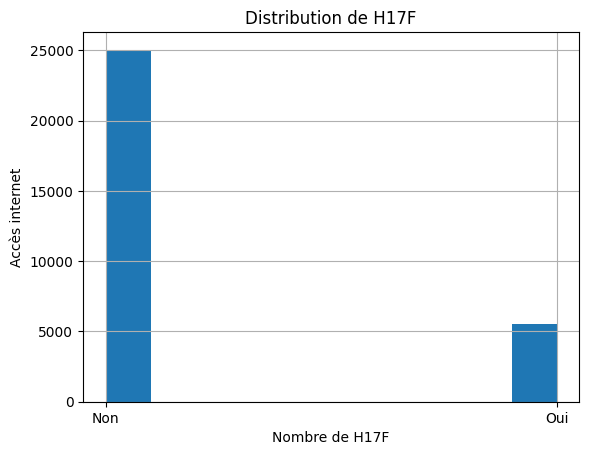

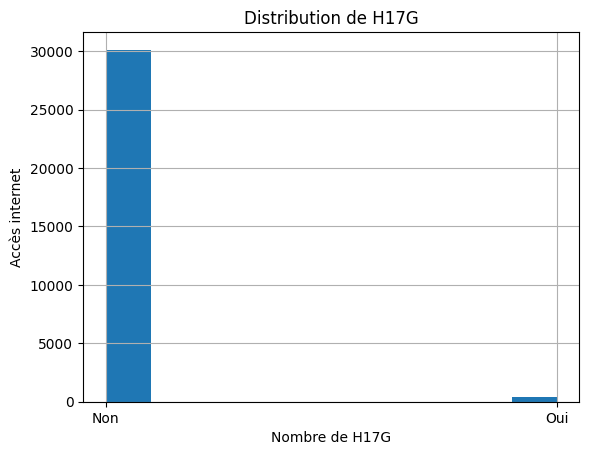

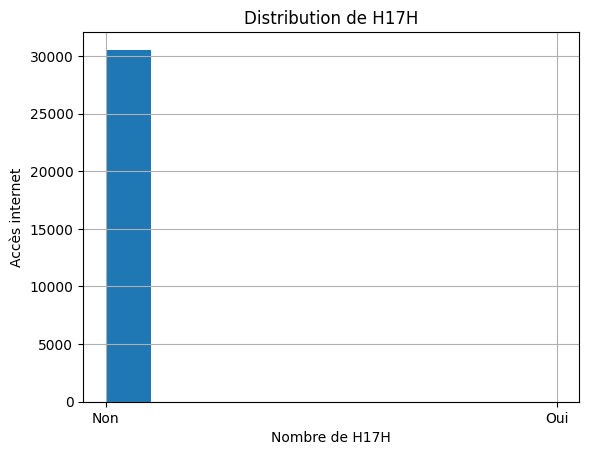

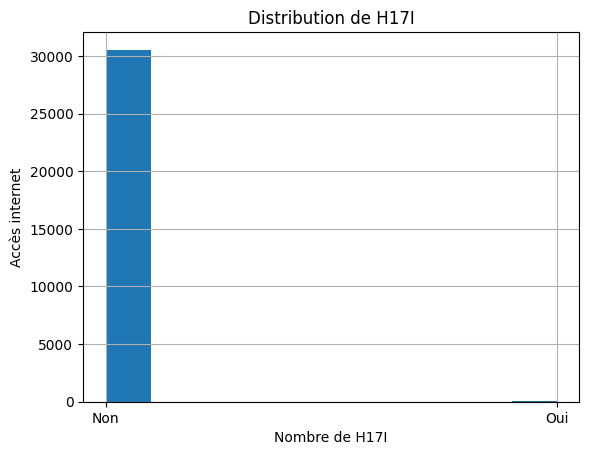

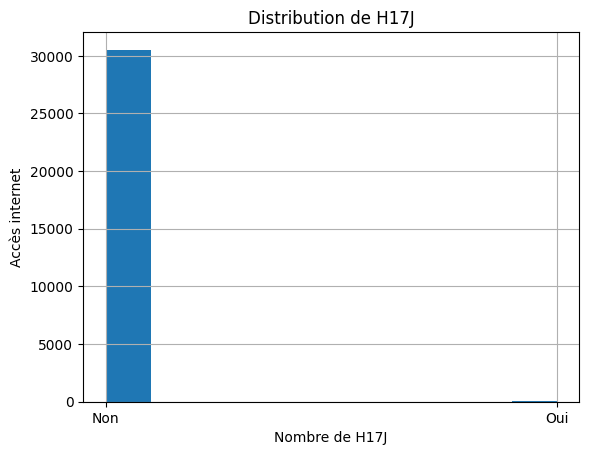

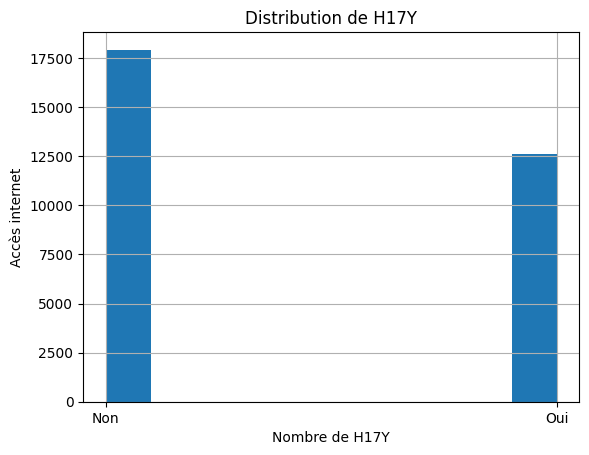

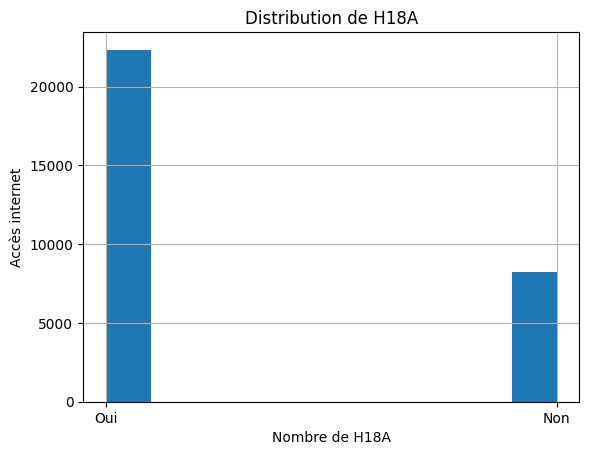

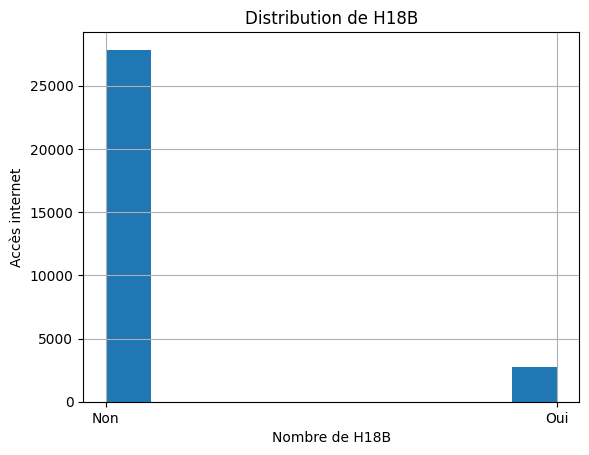

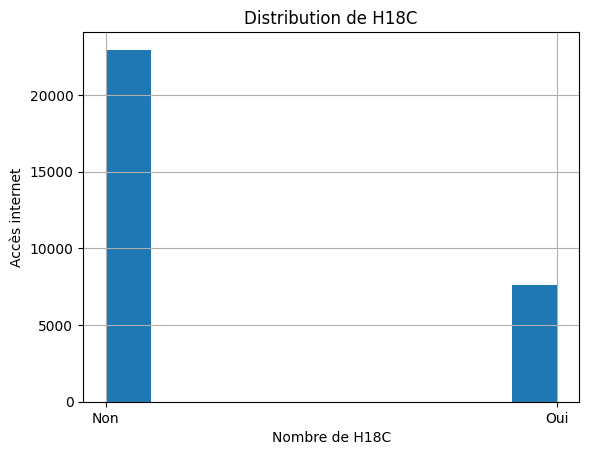

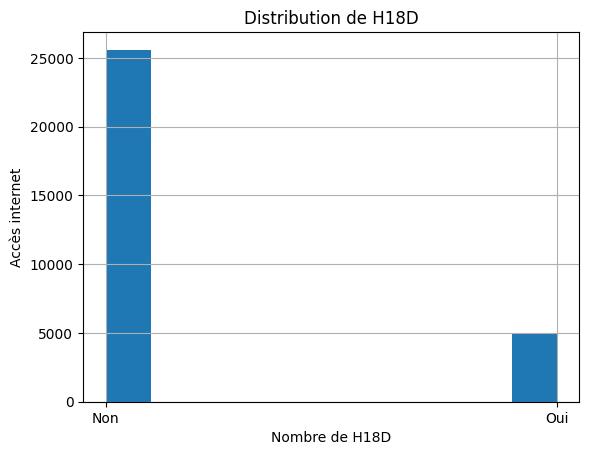

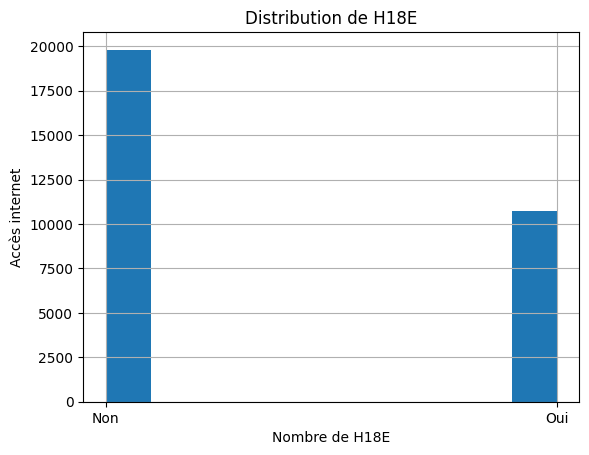

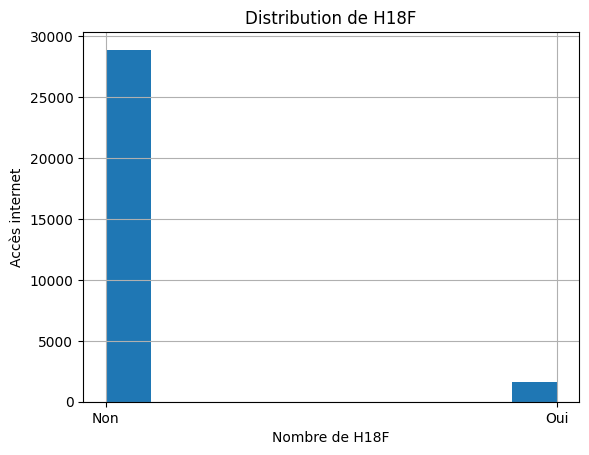

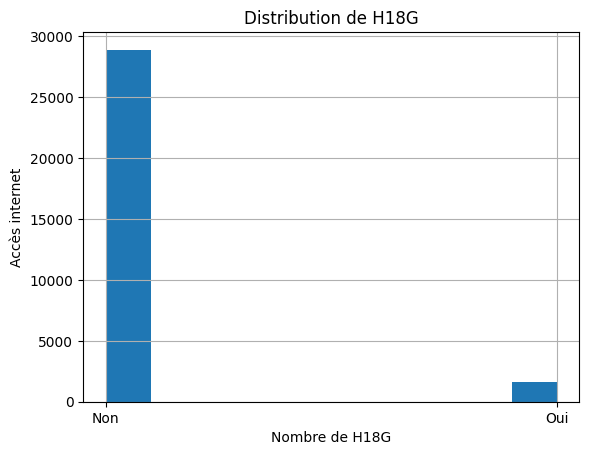

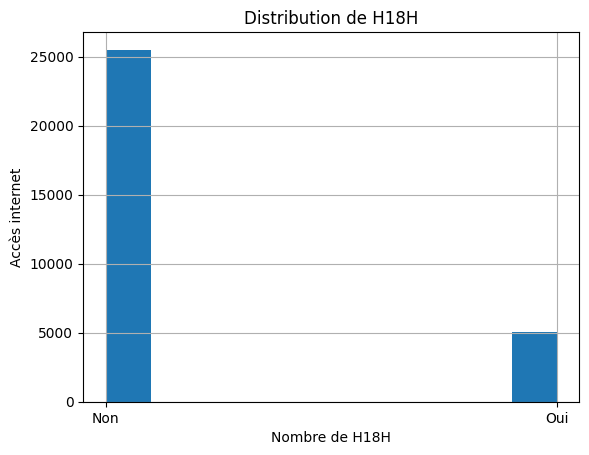

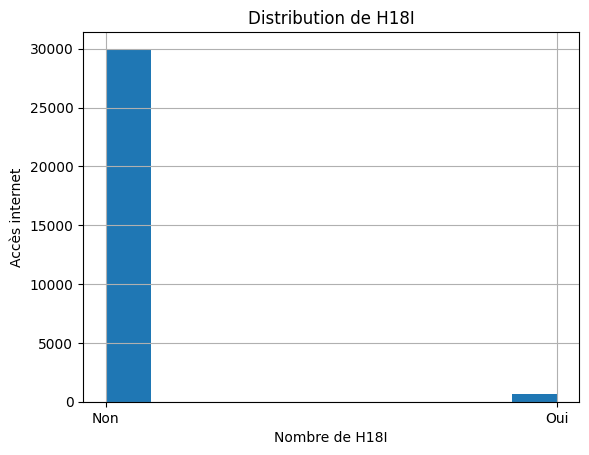

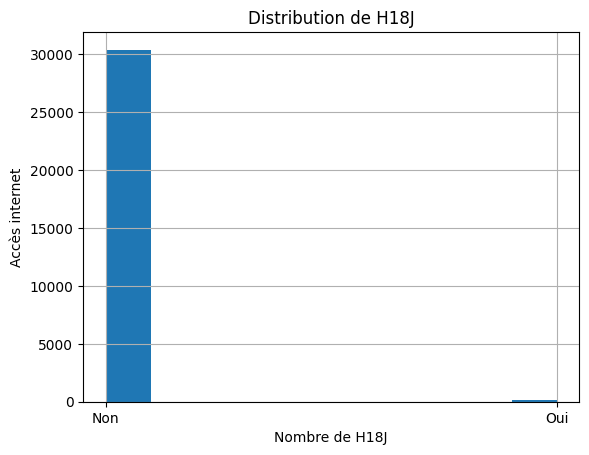

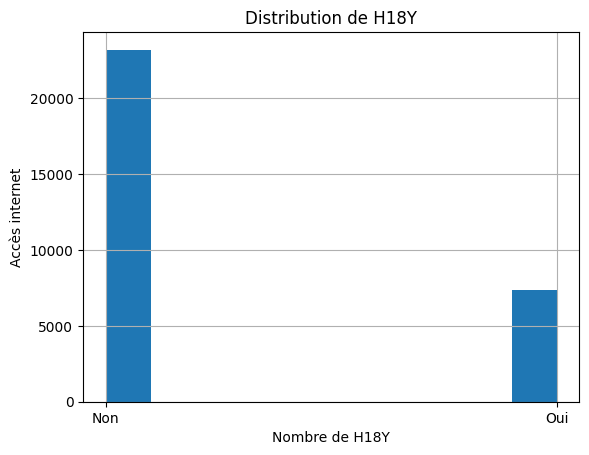

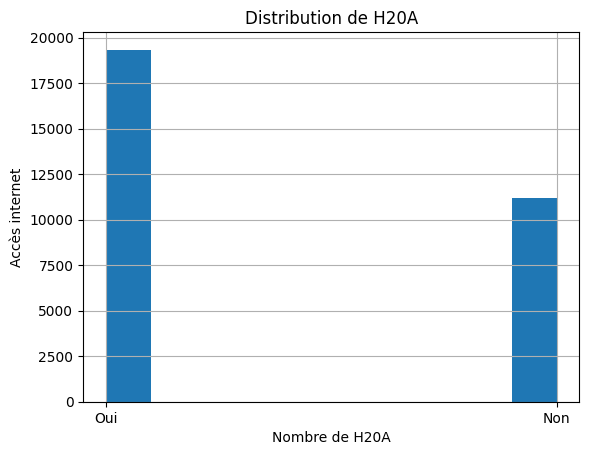

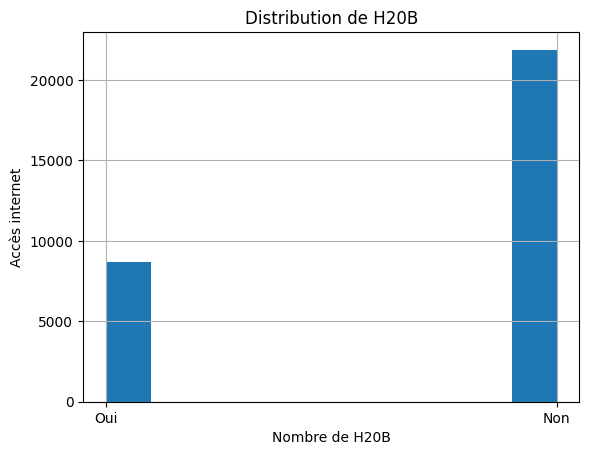

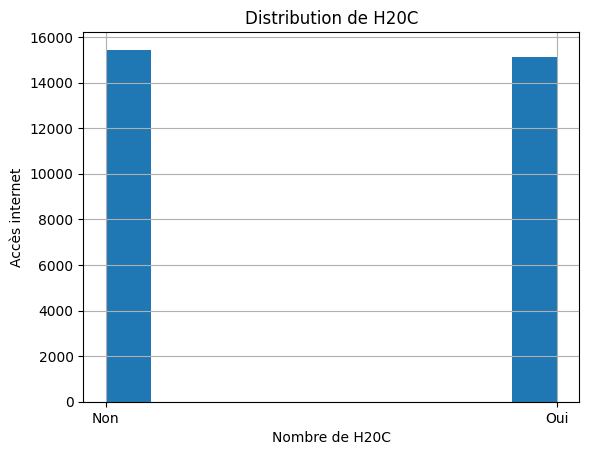

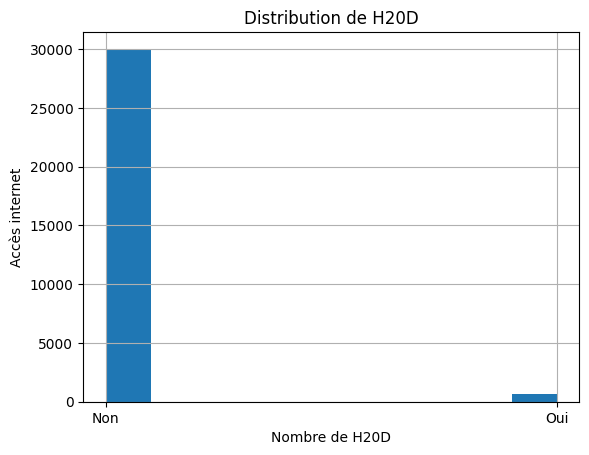

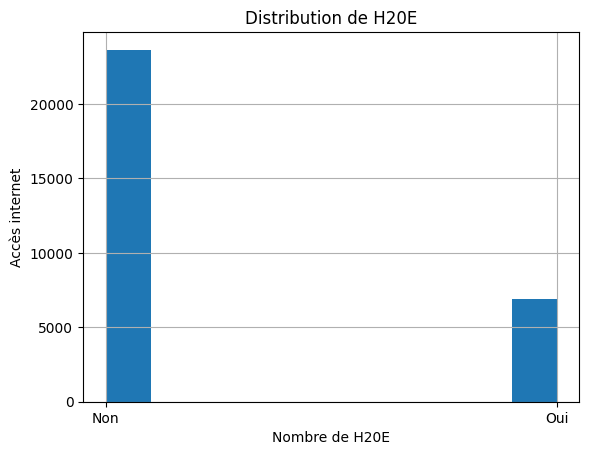

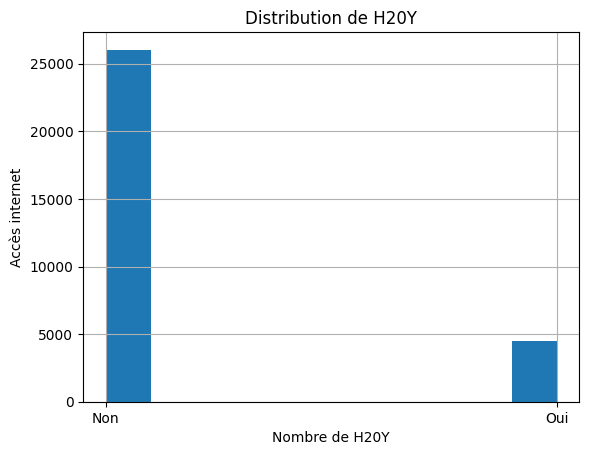

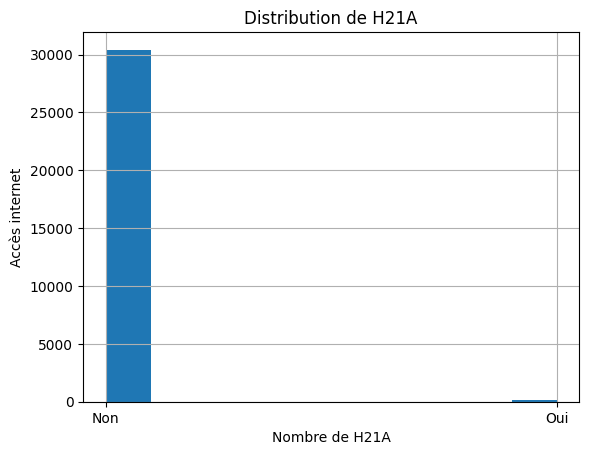

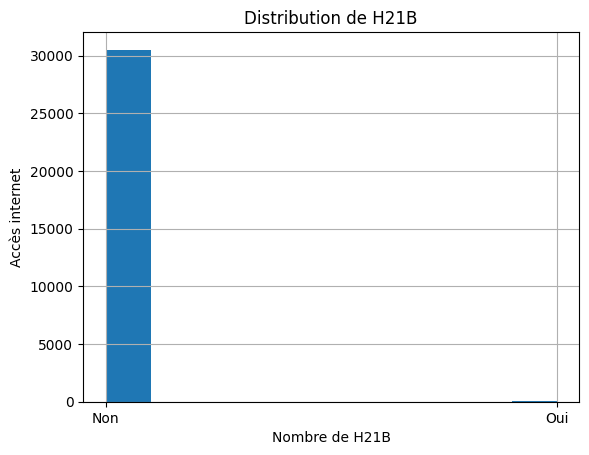

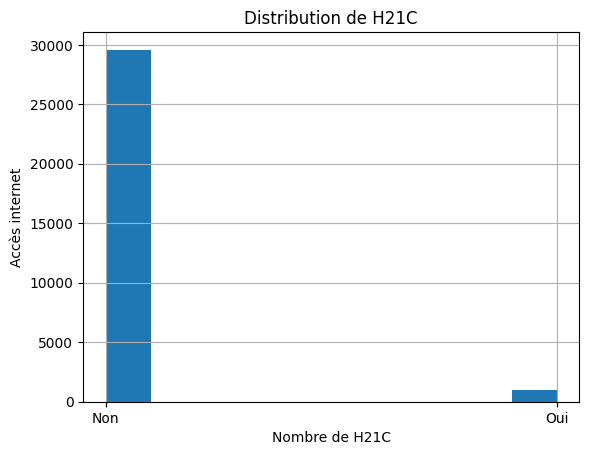

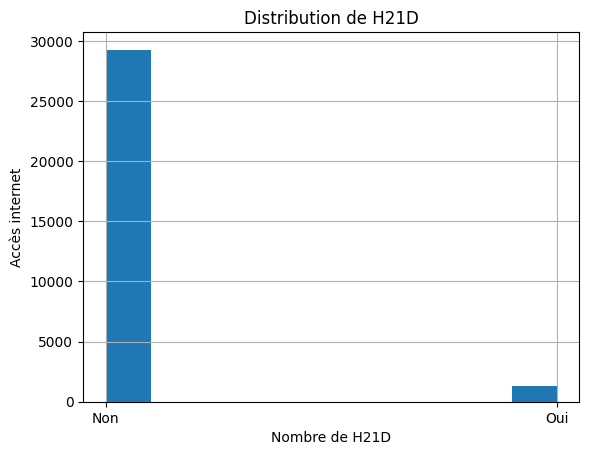

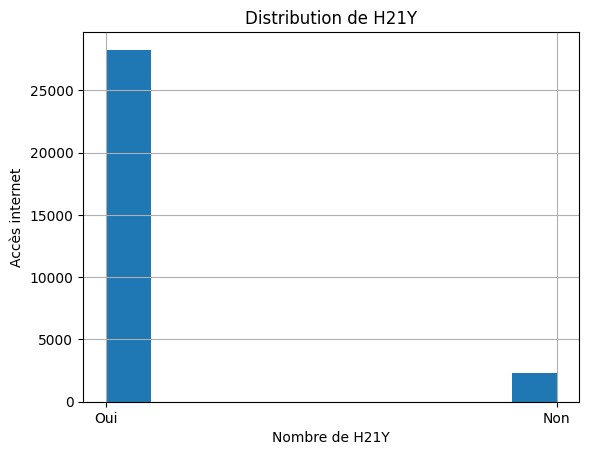

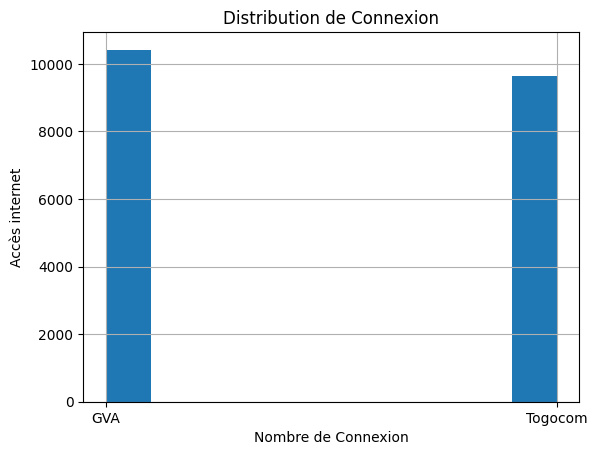

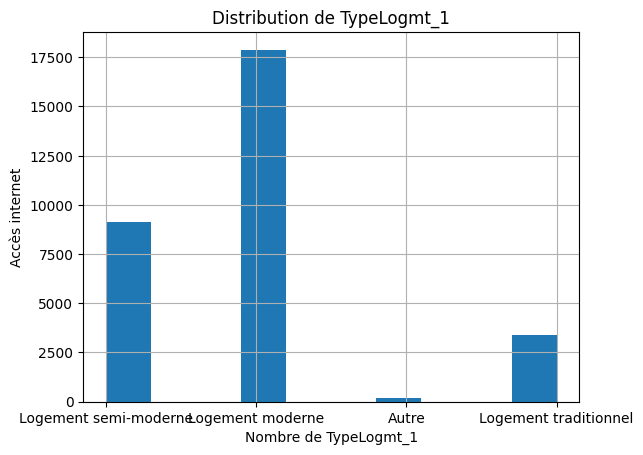

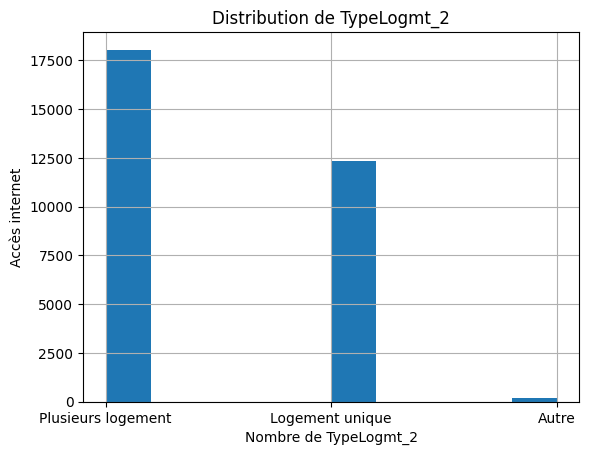

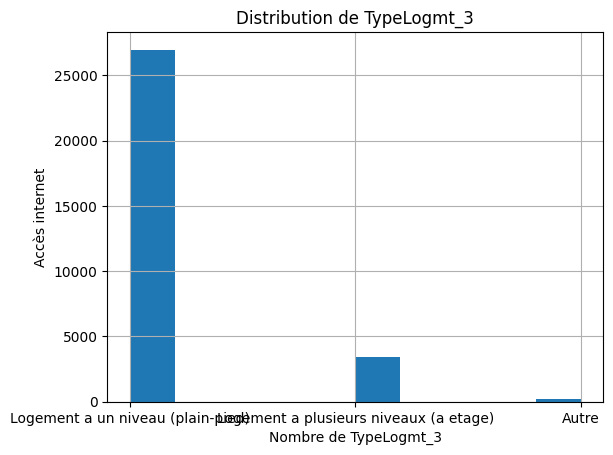

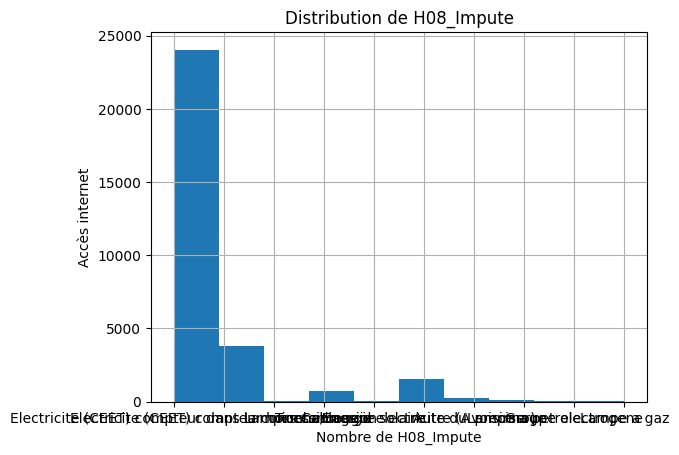

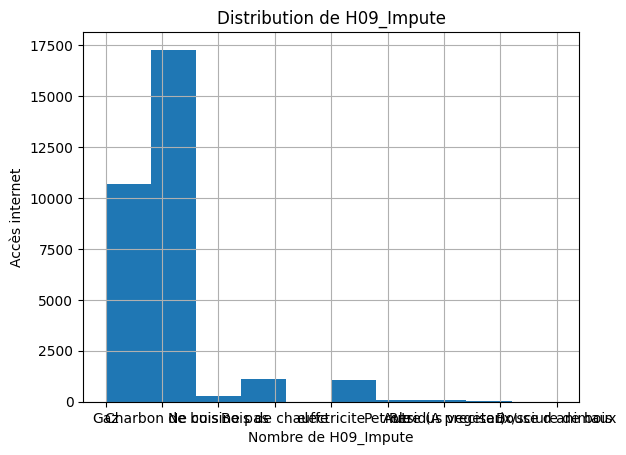

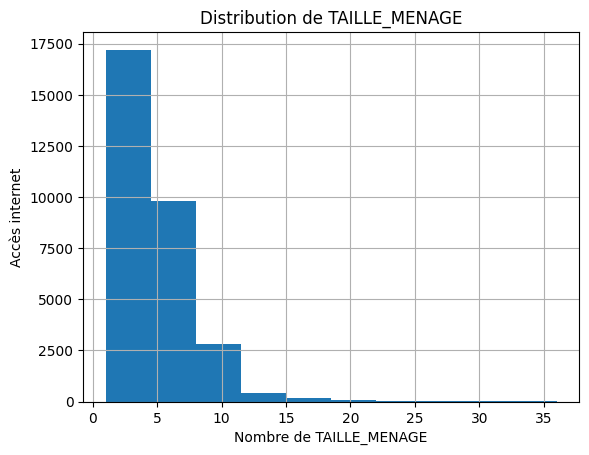

In [23]:
columns_to_plot = [c for c in train_data.select_dtypes('object') if len(c) == 4]
columns_to_plot += ['Connexion', 'TypeLogmt_1', 'TypeLogmt_2',
                   'TypeLogmt_3', 'H08_Impute', 'H09_Impute', 'TAILLE_MENAGE']

# Distribution des variables
for column in columns_to_plot:
    train_data[column].hist()
    plt.title(f'Distribution de {column}')
    plt.xlabel(f'Nombre de {column}')
    plt.ylabel("Accès internet")
    plt.show()

# *2. Utilisation de l'API "MOSAIKS"*
#### Utilisation des fonctionnalités provenant de la combinaison de l'Imagerie Satellite au Machine Learning (SIML).

In [24]:
display(train_data.columns.to_list().index('MOSAIK_FEATURE'))
display(train_data.columns.to_list().index(' .3999'))
display(train_data.columns.to_list().index('Target'))

42

4041

4042

In [25]:
# Assignation des variables
mosaik_X, mosaik_y = train_data.iloc[:, 42:4042], train_data.iloc[:, 4042]

### *Entraînons deux modèles (l'un optimisé) et comparons leurs performances*

In [26]:
%%time
# CPU times: total: 9min 20s (Kaggle)

# XGBoost
mosaik_model1 = XGBClassifier(learning_rate=0.27375137770957797, max_depth=10,
                             n_estimators=278)
mosaik_model1.fit(mosaik_X, mosaik_y)

CPU times: user 16min 19s, sys: 4.28 s, total: 16min 23s
Wall time: 4min 20s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.27375137770957797,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=278, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [27]:
%%time
# CPU times: total: 9min 20s (Kaggle)

# RandomForest
mosaik_model2 = RandomForestClassifier(random_state=RANDOM_SEED)
mosaik_model2.fit(mosaik_X, mosaik_y)

CPU times: user 2min 21s, sys: 114 ms, total: 2min 21s
Wall time: 2min 21s


RandomForestClassifier(random_state=42)

In [28]:
# Calcul des performances
xgb_ym_pred = mosaik_model1.predict_proba(mosaik_X)[:, 1]
rfc_ym_pred = mosaik_model2.predict_proba(mosaik_X)[:, 1]
roc1 = roc_auc_score(mosaik_y, xgb_ym_pred)
roc2 = roc_auc_score(mosaik_y, rfc_ym_pred)
print("ROC score (XGBoost) =>", roc1)
print("ROC score (RandomForest) =>", roc2)

ROC score (XGBoost) => 0.8619800013029864
ROC score (RandomForest) => 0.8618487682921707


#### Pourquoi une différence de performances si minime ?

*[Gemini] Si les données sont bruitées, il est possible que les deux modèles soient sensibles à ce bruit et ne parviennent pas à capturer efficacement la véritable structure sous-jacente des données. Cela pourrait expliquer pourquoi il n'y a pas de différence significative de performance entre eux. Mais le temps d'éxécution de l'un des modèles peut impacter sur le choix du modèle dans un processus de déploiement.*

**LE MODELE CHOISI POUR LA SUITE EST XGBOOST.**

In [29]:
# Prédictions sur les jeux d'entraînement et de test
train_data['MOSAIK_LABEL'] = mosaik_model1.predict_proba(mosaik_X)[:,1]
test_data['MOSAIK_LABEL'] = mosaik_model1.predict_proba(test_data.iloc[:, 42:4042])[:, 1]

# *3. Nettoyage des données*

In [30]:
# Manipulation des features
def feature_engineering(df):
    # Variables 'jugées' non-indispensables
    columns_to_check = ['ID', 'BoxLabel', 'UNKNOWN', 'H20Y', 'H17I', 'H17D', 'H21A', 'H17H', 'H17G']
    unecessary_columns = [c for c in columns_to_check if c in df.columns]
    unecessary_columns += [c for c in df.columns if c.startswith(' .')]
    tmp_df = df.drop(columns=unecessary_columns, axis=1)
    
    return tmp_df

In [31]:
# Définition du pre-processing
def preprocessing(df, is_train=True):
    df = feature_engineering(df)
    
    if is_train:
        X = df.drop('Target', axis=1)
        y = df.Target

        display(X.head(2))
        return X, y
    else:
        display(df.head(2))
        return df

In [32]:
X, y = preprocessing(train_data)

,TypeLogmt_1,TypeLogmt_2,TypeLogmt_3,H08_Impute,H09_Impute,TAILLE_MENAGE,H17A,H17B,H17C,H17E,H17F,H17J,H17Y,H18A,H18B,H18C,H18D,H18E,H18F,H18G,H18H,H18I,H18J,H18Y,H20A,H20B,H20C,H20D,H20E,H21B,H21C,H21D,H21Y,Connexion,MOSAIK_FEATURE,MOSAIK_LABEL
0,Logement semi-moderne,Plusieurs logement,Logement a un niveau (plain-pied),Electricite (CEET) compteur dans la concession,Gaz,1.0,Non,Oui,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Non,Non,Non,Oui,Oui,Non,Non,Non,Non,Non,Non,Oui,GVA,0.110878,0.771848
1,Logement semi-moderne,Plusieurs logement,Logement a un niveau (plain-pied),Electricite (CEET) compteur dans la concession,Gaz,4.0,Non,Oui,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Non,Oui,Non,Oui,Non,Oui,Non,Non,Non,Oui,GVA,0.070467,0.186839


In [33]:
test_df = preprocessing(test_data, is_train=False)

,TypeLogmt_1,TypeLogmt_2,TypeLogmt_3,H08_Impute,H09_Impute,TAILLE_MENAGE,H17A,H17B,H17C,H17E,H17F,H17J,H17Y,H18A,H18B,H18C,H18D,H18E,H18F,H18G,H18H,H18I,H18J,H18Y,H20A,H20B,H20C,H20D,H20E,H21B,H21C,H21D,H21Y,Connexion,MOSAIK_FEATURE,MOSAIK_LABEL
0,Logement moderne,Logement unique,Logement a plusieurs niveaux (a etage),Electricite (CEET) compteur hors concession,Charbon de bois,5.0,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Oui,Non,Non,Non,Non,Non,Non,Non,Oui,Non,Non,Non,Non,Non,Oui,Non,Togocom,0.176887,0.692422
1,Logement moderne,Plusieurs logement,Logement a un niveau (plain-pied),Electricite (CEET) compteur dans la concession,Gaz,9.0,Non,Oui,Non,Non,Non,Non,Non,Oui,Non,Oui,Non,Oui,Non,Oui,Non,Non,Non,Non,Oui,Non,Oui,Non,Non,Non,Non,Non,Oui,Togocom,0.151004,0.689610


In [34]:
# Subdivision des features numériques des features catégorielles
numerical_cols = make_column_selector(dtype_include=np.number)
categorical_cols = make_column_selector(dtype_exclude=np.number)
display(numerical_cols)
display(categorical_cols)

In [35]:
# Définition des pipelines
cat_pipeline = make_pipeline(OrdinalEncoder(
    handle_unknown='use_encoded_value', 
    unknown_value=-1), SimpleImputer(add_indicator=True))
num_pipeline = make_pipeline(RobustScaler())

# Définition des transformers
preprocessor = make_column_transformer((cat_pipeline, categorical_cols), 
                                       (num_pipeline, numerical_cols))

In [36]:
# Dimensions
X.shape, test_df.shape

((30558, 36), (13097, 36))

# *4. Modélisation | Technique de Stacking*
## Modèles de base (En cours d'élaboration)

#### Pour plus d'informations sur cette implémentation, consulter [sklearn stacking method](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [37]:
# randomtreesclassifier score : 0.9204938429024591 
rfc_model = make_pipeline(preprocessor, RandomForestClassifier(
    verbose = False, random_state=RANDOM_SEED, n_estimators=778,
    min_samples_split=5, max_depth=49, n_jobs=-1))

# catboostclassifier score : 0.9099881292457737
cbc_model = make_pipeline(preprocessor, CatBoostClassifier(verbose=False, 
                                            learning_rate=0.32,
                                            n_estimators=111,
                                            max_depth=10,
                                            bagging_temperature=0, 
                                            random_state=RANDOM_SEED))

# xgbclassifier score : 0.9101663145816742
xgb_model = make_pipeline(preprocessor, XGBClassifier(eval_metric='auc',
                                                    max_depth=9,
                                                    n_estimators=280,
                                                    reg_lambda=0.16720615131736327,
                                                    reg_alpha=0.7396354259591014,
                                                    learning_rate=0.06256888717877579,
                                                    subsample=0.7705885926615464,
                                                    colsample_bytree=0.8916761351185414,
                                                    min_child_weight=1,
                                                    gamma=0.07017155263198513,
                                                    random_state=RANDOM_SEED))

# extratreesclassifier score : 0.9144351918919655
ext_model = make_pipeline(preprocessor, ExtraTreesClassifier(verbose = False,
                                                    n_estimators=78,
                                                    max_depth=28, n_jobs=-1,
                                                    random_state=RANDOM_SEED))

# lgbmclassifier score : 0.9123984818345354
lgb_model = make_pipeline(preprocessor, LGBMClassifier(max_depth=10,
                                        num_leaves=131, n_estimators=294, 
                                        learning_rate=0.252, verbose=-1,
                                        random_state=RANDOM_SEED))

# adaboostclassifier score : 0.889794366128154
adb_model = make_pipeline(preprocessor, AdaBoostClassifier(n_estimators=240,
                                algorithm='SAMME.R',random_state=RANDOM_SEED))

# kneighbors classifier : 0.8903158340901796
knc_model = make_pipeline(preprocessor, KNeighborsClassifier(n_neighbors=20,
                                                            weights='distance',
                                                            metric='manhattan', 
                                                            p=4))

# svc score : 0.8730317578219597
svc_model  = make_pipeline(preprocessor, SVC())

In [38]:
# Définition du méta-modèle et du stacking classifier
model_z = StackingClassifier(verbose=1, cv=SKF, n_jobs=-1,
             estimators=[('RFC1', rfc_model),
                         ('EXT1', ext_model),
                         ('CBC1', cbc_model),
                         ('XGB1', xgb_model),
                         ('LGB1', lgb_model),
                         ('ADB1', adb_model),
                         ('KNC1', knc_model),
                         ('SVC1', svc_model)],
                         final_estimator=CatBoostClassifier(
                             max_depth = 9, random_state=RANDOM_SEED,
                             n_estimators = 110, verbose = False,
                             learning_rate = 0.04188680592453651))

list_models = (rfc_model, ext_model, cbc_model, xgb_model, lgb_model, 
               adb_model, knc_model, svc_model, model_z)

# *5. Procédure d'évaluation*

In [39]:
# Quelles sont les variables les plus utiles ?
def output_feature_importances(model_to_use, data_from):
    feature_importances = model_to_use.feature_importances_
    feature_names = data_from.columns.to_list()
    feature_names.append('MissingIndicator') # De SimpleImputer indicator flag
    
    importance_df = pd.DataFrame({
        'Names': feature_names,
        'Importances': feature_importances
    }).sort_values(by='Importances', ascending=False)
    
    plt.figure(figsize=(10,8))
    plt.grid()
    sns.barplot(x='Importances', y='Names', data=importance_df)
    plt.show()

In [40]:
# Evaluation d'une liste de modèles basés sur des entrées données
def evaluation(models, X_input, y_input):
    for model in models:
        scores = cross_val_score(model, X_input, y_input, 
                                 scoring='roc_auc', cv=SKF, n_jobs=-1, 
                                 verbose=True)
        model.fit(X_input, y_input)
        roc_score = roc_auc_score(y_input, model.predict_proba(X_input)[:, 1])
        
        if hasattr(model, 'steps'):
            print(f"{model.steps[-1][0]} score (train) : {roc_score}")
            print(f"ESTIMATION {model.steps[-1][0]} => {scores.mean()}")
        else:
            print(f"{model.__class__.__name__} Score (input) : {roc_score}")
            print(f"ESTIMATION {model.__class__.__name__} => {scores.mean()}")

In [41]:
# Evaluation d'un unique modèle sur des entrées données
def one_evaluation(model_to_evaluate, X_input, y_input):
    scores = cross_val_score(model_to_evaluate, X_input, y_input, 
                            scoring='roc_auc', cv=SKF, n_jobs=-1, 
                            verbose=True)
    roc_score = scores.mean()
    
    if hasattr(model_to_evaluate, 'steps'):
        print(f"{model_to_evaluate.steps[-1][0]} score : {roc_score}")
    else:
        print(f"{model_to_evaluate.__class__.__name__} score : {roc_score}")
        
    return roc_score

In [42]:
# Optimisation des hyperparamètres avec la librairie Optuna
def objective(trial):
    # Suggestion des hyperparamètres
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
    }

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        
        # Créer le classificateur avec les hyperparamètres de suggestion
        catboost_final_estimator = CatBoostClassifier(verbose=False, 
                                                      **params)
        model_z.set_params(final_estimator=catboost_final_estimator)
        model_to_optimize = model_z

        # Métrique à optimiser
        score = one_evaluation(model_to_optimize, X, y)
        return score

In [43]:
# Définition de la fonction de cross validation
def run_cross_validation(model_to_cross):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        scores = cross_val_score(model_to_cross, X, y, 
                                 scoring='roc_auc', cv=SKF, n_jobs=-1, 
                                 verbose=True)
        
        print(f"SCORES DE VALIDATION => {scores}")
        print(f"ESTIMATION => {scores.mean()}")
        model_to_cross.fit(X, y)

In [44]:
%%time
### CPU times: total: Dépend de la valeur de [WHAT_TO_DO] (Kaggle)

# QUE FAIRE ?
WHAT_TO_DO = 4

if WHAT_TO_DO == 1:
    # Evaluation d'un modèle unique
    one_evaluation(rfc_model, X, y)
    
elif WHAT_TO_DO == 2:
    # Lancer OPTUNA (initialiser une nouvelle recherche, faire du HPO)
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    print("Meilleurs hyperparamètres: ", study.best_params)
    print("Meilleur score: ", study.best_value)
    
elif WHAT_TO_DO  == 3:
    # Expérimenter des hypothèses (uniquement sur les arbres)
    try_n_estimators()
    try_max_depth()
    
elif WHAT_TO_DO == 4:
    # Le modèle développé est-il robuste ? performant ? stable ?
    # SCORES DE VALIDATION => [0.92432385 0.92770848 0.9208205  
    # 0.92377448 0.92215523]
    # ESTIMATION => 0.923756506236136
    run_cross_validation(model_z)
    
elif WHAT_TO_DO == 5:
    # Evaluation de tous les modèles
    evaluation(list_models, X, y)
    
else:
    # Actualisation
    ...

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


SCORES DE VALIDATION => [0.91767886 0.92208973 0.93010764 0.92424058 0.92618544]
ESTIMATION => 0.9240604507437629


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 25.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   33.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   36.1s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   26.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.1min finished


CPU times: user 17.3 s, sys: 6.01 s, total: 23.3 s
Wall time: 31min 18s


# *6. Prédictions / Output*

In [45]:
# Prédictions sur le jeu de test
test_preds = model_z.predict_proba(test_df)[:, 1]

# COMMENTER LA LIGNE SUIVANTE SI LES PROBABILITES BRUTES SONT REQUISES
test_preds = np.round(test_preds, 2)
display(test_preds)

array([0.77, 0.75, 0.82, ..., 0.86, 0.89, 0.01])

In [46]:
# Créer le Dataframe de soumission
submission_df = pd.DataFrame({
    'ID': test_ID,
    'Target': test_preds
})

# Générer le fichier CSV de sortie
output_filename = 'TestSubmission' + str(time.time())
submission_df.to_csv(data_output + output_filename + '.csv', index=False)
print(output_filename)

TestSubmission1722374760.5315988


# II. Justification de la solution / Critiques

## a - Justification

"La majorité, dont chaque membre pris à part n'est pas un homme remarquable, est cependant au-dessus des hommes supérieurs.", Aristote - *La politique*.

Cette assertion d'un philosophe aussi célèbre illustre bien le principe central de l'effet: [THE WISDOM OF THE CROWD](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd)(Loi des grands nombres).
En effet, il est souvent relaté que l'avis d'une foule d'amateurs est bien meilleur que celui d'un expert tout seul. Mais pour cela, il faut remplir trois grands critères à savoir:

* La diversité : tous les modèles ne doivent pas avoir les mêmes marges d'erreurs sur les mêmes échantillons. 
* La compétence : tous les modèles doivent avoir plus de 50% des prédictions précises.
* La taille : le ratio approprié de modèles à entraîner.

Pour obtenir des performances très élévées et une stabilité au niveau des prédictions, 08 modèles de base ont été choisis:

* RandomForest : Utilisation du Bagging
* ExtraTrees : Utilisation du Bagging
* XGBoost : Utilisation du Boosting
* CatBoost : Utilisation du Boosting (Estimateur final pour sa robustesse)
* LGBM : Utilisation du Boosting (approche différente -leaf-wise)  
* AdaBoost : Utilisation du Boosting
* KNeighbors : Utilisation de l'approche des k-plus proches voisins
* SVC : Recherche d'un hyperplan optimisé pour les échantillons du dataset

##### *Avantages:*

1. Amélioration de la Précision Prédictive : En combinant divers modèles, l'empilement peut atteindre une précision plus élevée que celle des modèles individuels.

2. Gestion des Relations Complexes : L'empilement peut capturer des relations complexes dans les données, qui pourraient être difficiles à détecter pour des modèles individuels.

##### *Considérations et Bonnes Pratiques*
Pour un empilement réussi :

1. Diversité des Modèles : S'assurer de la diversité parmi les modèles de base pour éviter la redondance dans leurs prédictions.

2. Validation Croisée : Utiliser la validation croisée pendant l'entraînement pour évaluer correctement la performance du modèle empilé.

##### *Applications Réelles*

1. Compétitions Kaggle : De nombreuses solutions gagnantes sur Kaggle utilisent l'empilement pour atteindre les meilleurs rangs.

2. Diagnostic Médical : L'empilement peut combiner différentes mesures diagnostiques pour des prédictions médicales plus précises.

## b - Critiques

1. Manque d'Interprétabilité : Les modèles empilés peuvent être difficiles à interpréter, surtout comparés à des modèles plus simples comme les arbres de décision ou les régressions linéaires. Cette opacité peut poser des problèmes dans des domaines où l'interprétabilité est cruciale, comme le médical ou le juridique.

2. Coûts Computationnels Élevés : L'entraînement et la prédiction avec plusieurs modèles peuvent être coûteux en termes de temps et de ressources computationnelles. Cela peut poser des problèmes pratiques, surtout avec des ensembles de données volumineux ou dans des environnements de production.


# III. Conclusion

Ce défi a été une immense opportunité de mettre en avant mes compétences techniques dans le domaine du Machine Learning. Je sors de ce projet non seulement avec des compétences acquises et améliorées, mais aussi avec une plus grande confiance en mes capacités à relever des défis futurs dans le domaine du Machine Learning.

# REFERENCES

[ Rolf et al. “A generalizable and accessible approach to machine learning with global satellite imagery.” Nature Communications (2021).](https://www.nature.com/articles/s41467-021-24638-z)

[Understanding Stacking Classifiers: A Comprehensive Guide.](https://sharmasaravanan.medium.com/understanding-stacking-classifiers-a-comprehensive-guide-195bfab58e48)

[Takuya Akiba, Shotaro Sano, Toshihiko Yanase, Takeru Ohta, and Masanori Koyama. 2019.
Optuna: A Next-generation Hyperparameter Optimization Framework. In KDD.](https://optuna.org/)

[Optuna vs Hyperopt: Which Hyperparameter Optimization Library Should You Choose?](https://neptune.ai/blog/optuna-vs-hyperopt)

[Stack machine learning models: Get better results](https://developer.ibm.com/articles/stack-machine-learning-models-get-better-results/)

-----------------------------------------------------------------------------